In [ ]:
#"""
#credit_shap_project.py
#Complete pipeline: load or generate CSV -> preprocess -> tune LightGBM with Optuna ->
#evaluate -> SHAP global + local explanations -> save plots + CSV + text outputs.

 #Requirements:
# pip install pandas numpy scikit-learn lightgbm optuna shap matplotlib seaborn joblib
#"""

import os
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

# ML / tuning / explainability
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, classification_report
import lightgbm as lgb
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'optuna'

DataFrame columns: Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 4596, number of negative: 21468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176335 -> initscore=-1.541377
[LightGBM] [Info] Start training from score -1.541377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



===== MODEL RESULTS =====
AUC Score: 0.8982195850989456
F1 Score: 0.5142364106988784

Classification Report:
              precision    recall  f1-score   support

           N       0.90      0.89      0.89      5368
           Y       0.51      0.52      0.51      1149

    accuracy                           0.83      6517
   macro avg       0.70      0.71      0.70      6517
weighted avg       0.83      0.83      0.83      6517



 99%|===================| 6420/6517 [00:22<00:00]       


Generating Global SHAP Summary Plot...


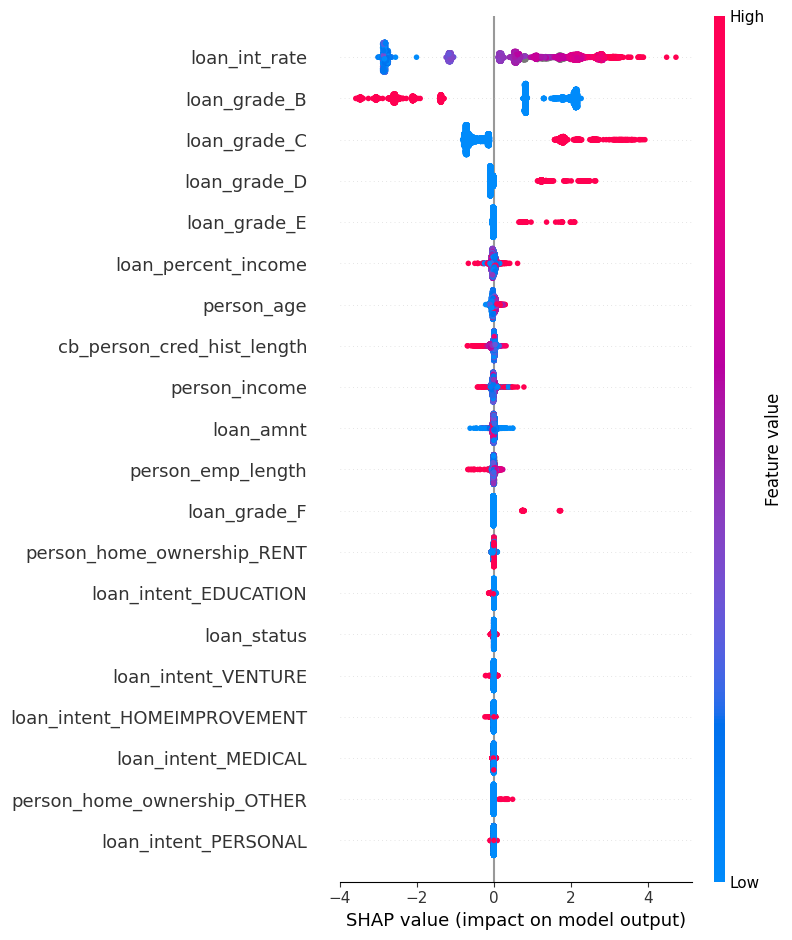

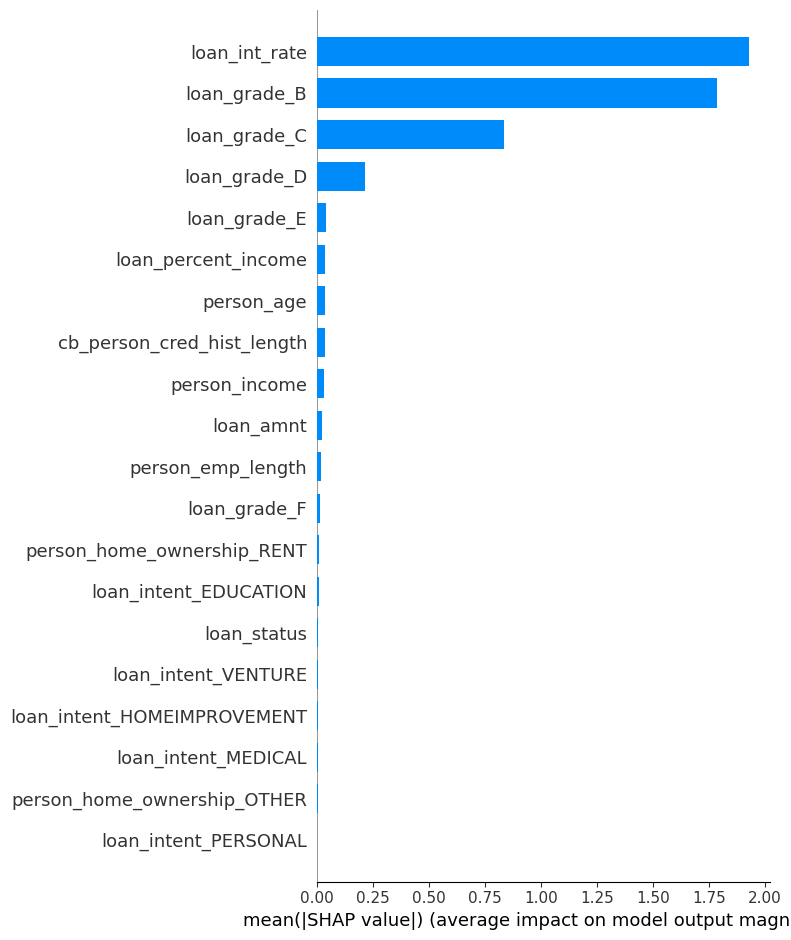


5 HIGH RISK CASES SELECTED:
     default      risk
1971       N  0.859535
3891       Y  0.845603
384        Y  0.823531
4159       N  0.819038
4648       Y  0.803159

5 LOW RISK CASES SELECTED:
     default      risk
3735       N  0.000058
3141       N  0.000059
6208       N  0.000065
1342       N  0.000066
5148       N  0.000066
High Risk Case 1


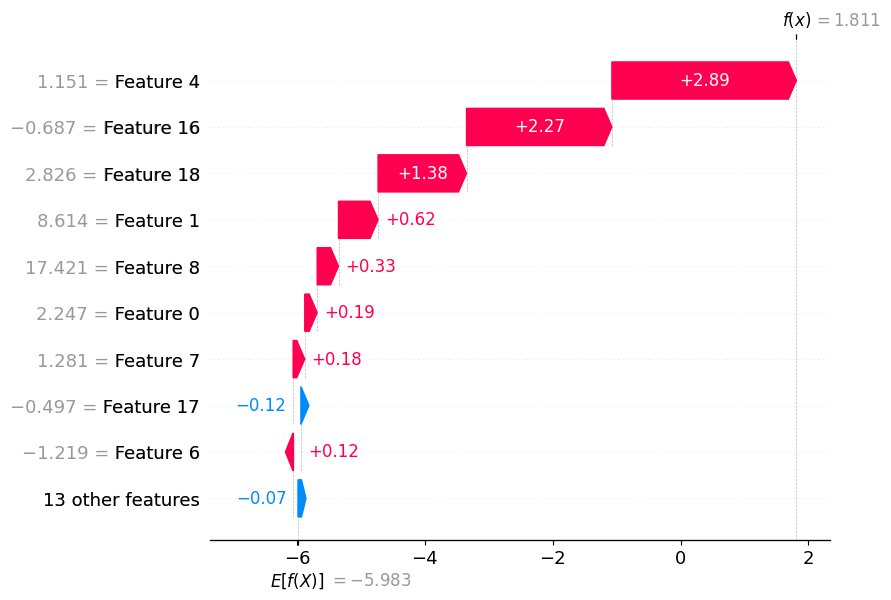

High Risk Case 2


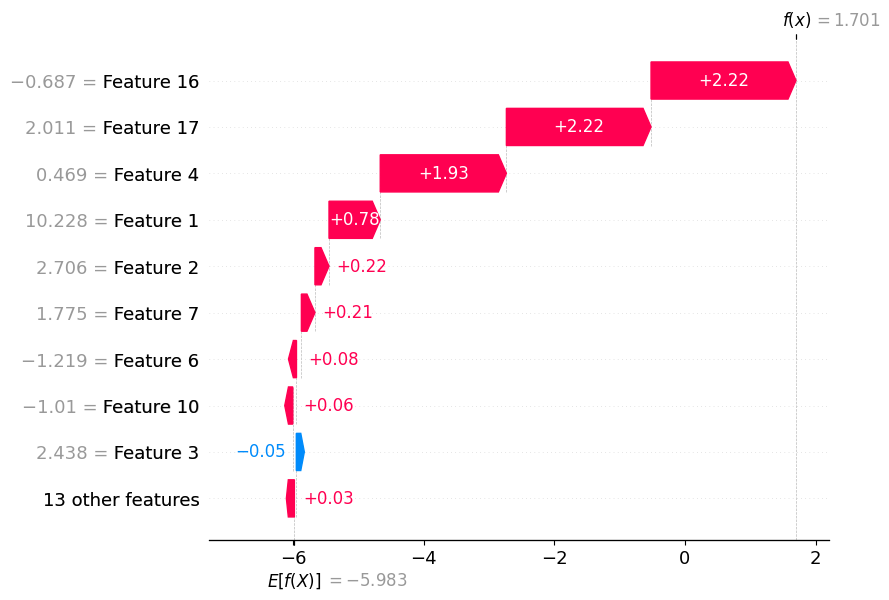

High Risk Case 3


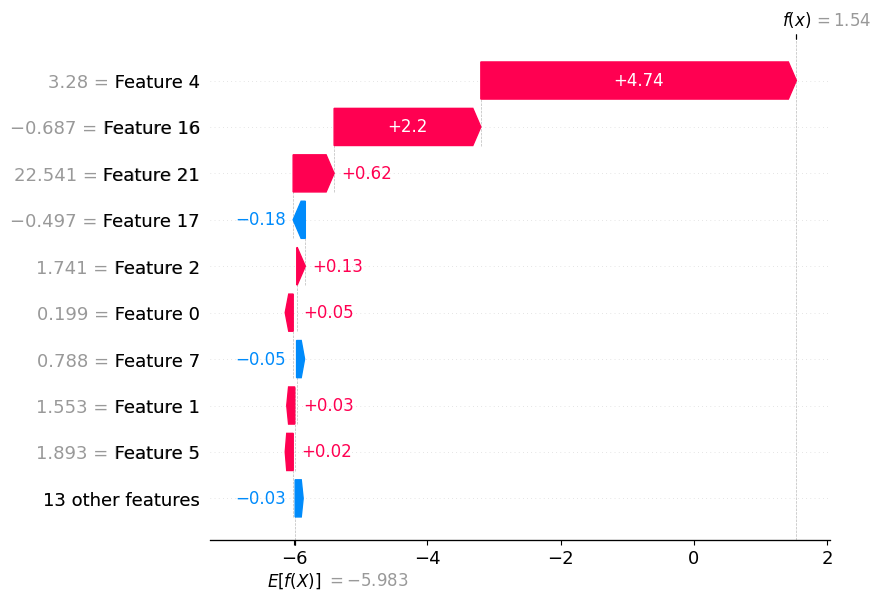

High Risk Case 4


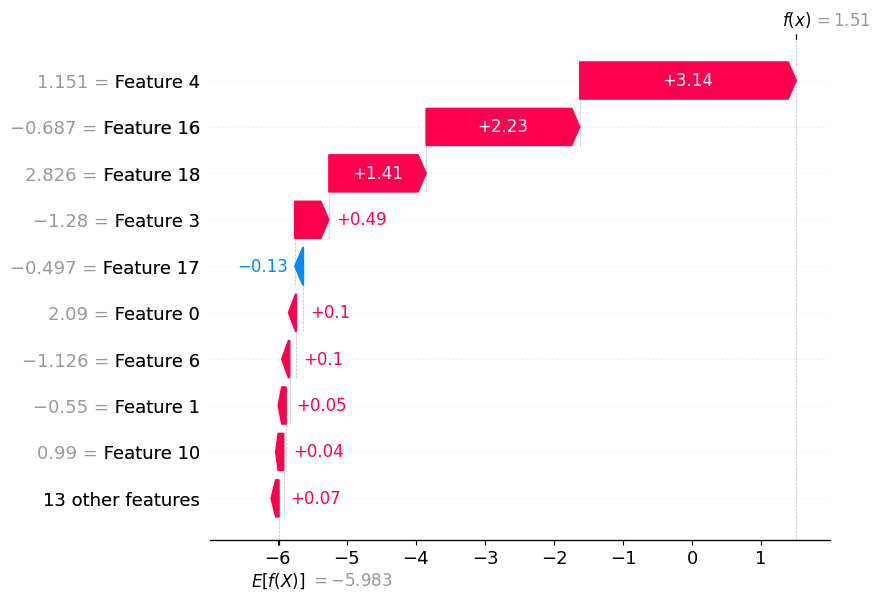

High Risk Case 5


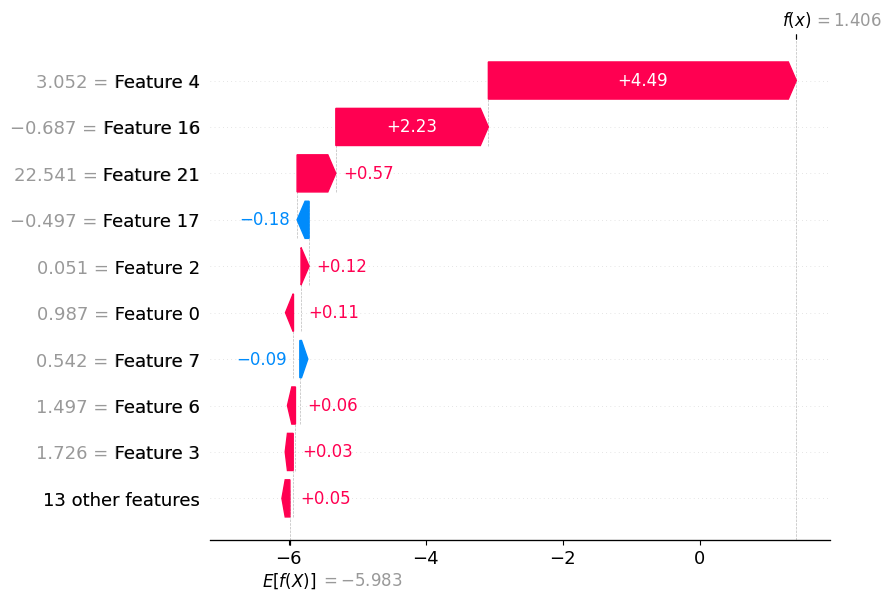

Low Risk Case 1


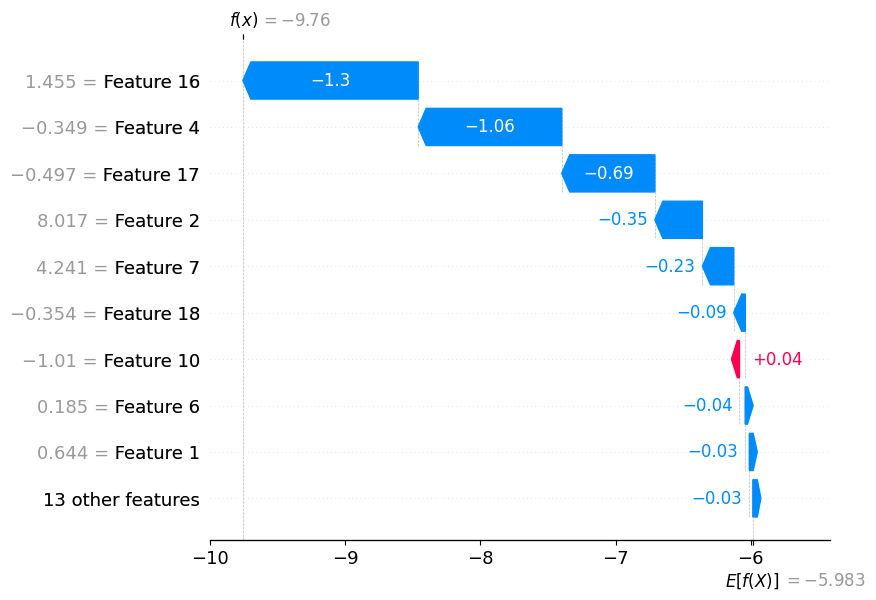

Low Risk Case 2


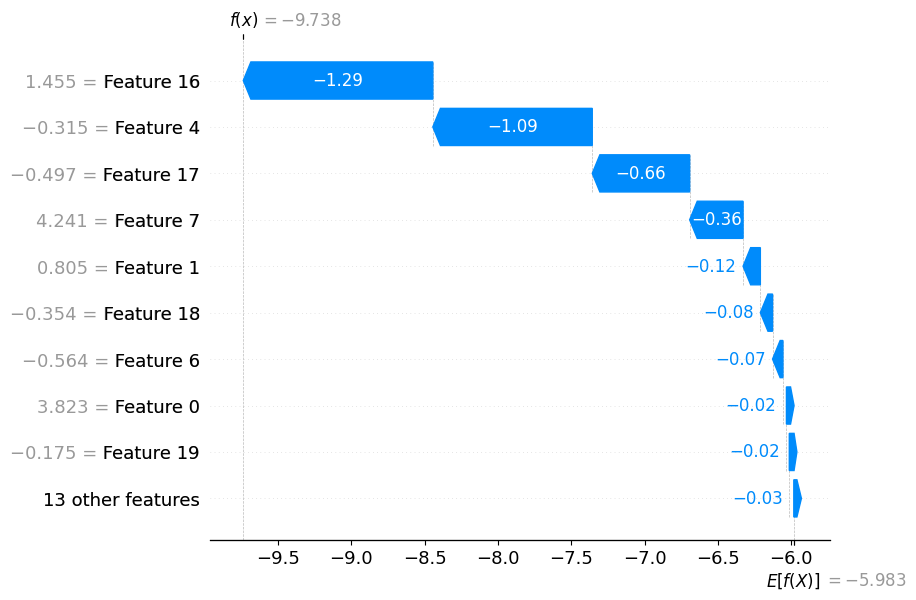

Low Risk Case 3


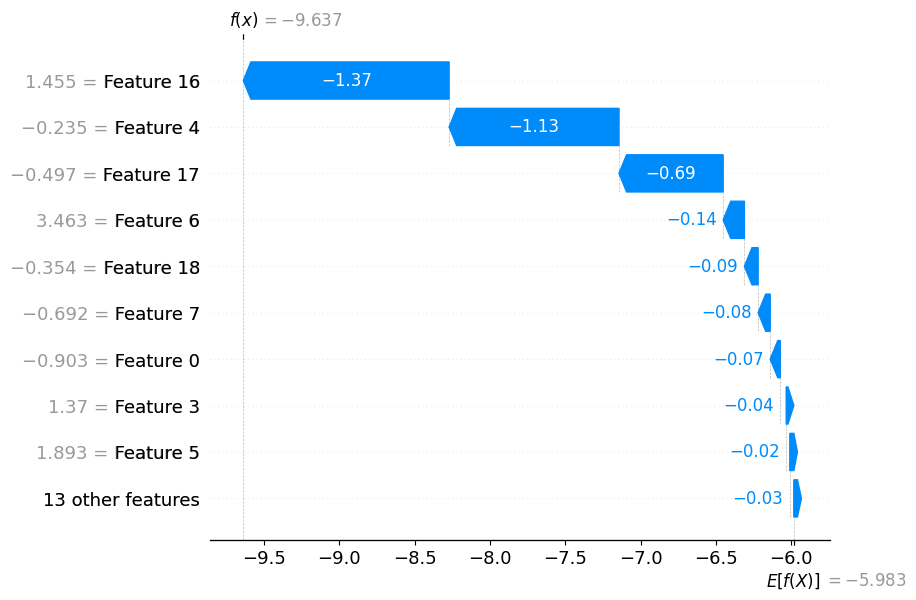

Low Risk Case 4


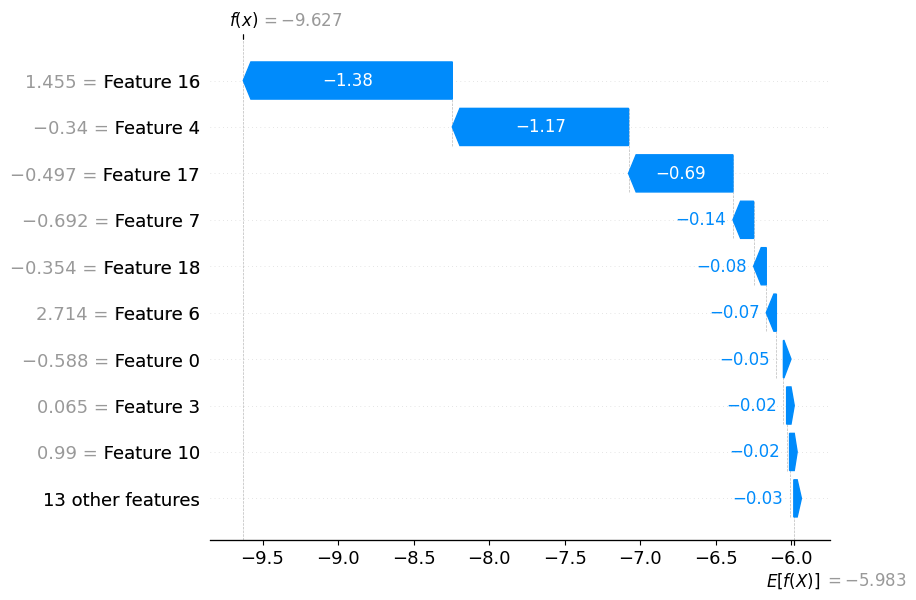

Low Risk Case 5


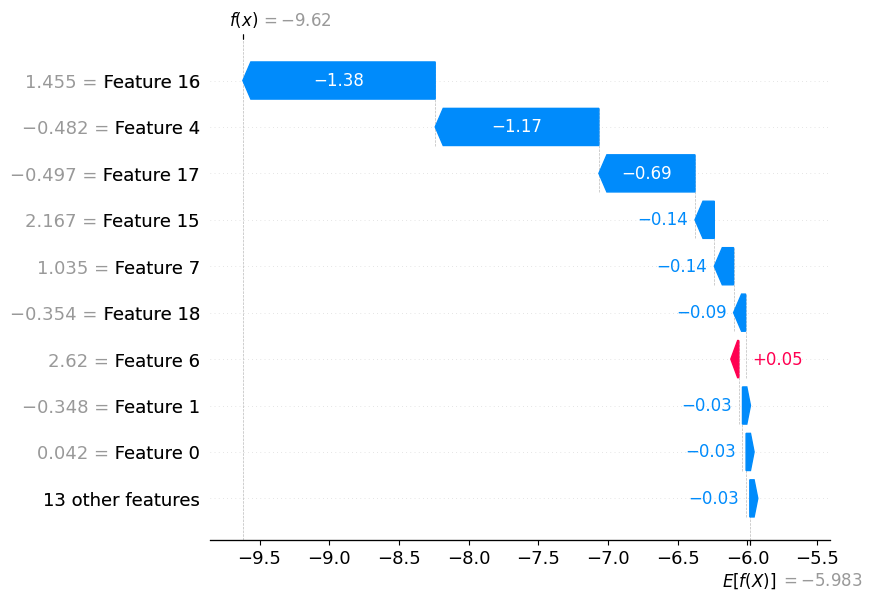

In [ ]:
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

# ======================================
# 1. LOAD DATA
# Replace with your dataset filename
# ======================================

df = pd.read_csv("/content/drive/MyDrive/credit_risk_dataset.csv")

# Assuming target column is named "default"
# ERROR: The column 'default' was not found in the DataFrame.
# Please inspect `df.columns` to find the correct target column name
# and update the 'target' variable below.
print("DataFrame columns:", df.columns)
target = "cb_person_default_on_file" # <<< Updated this line to fix the KeyError

X = df.drop(columns=[target])
y = df[target]

# Handle categorical encoding if needed
X = pd.get_dummies(X, drop_first=True)

# Scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======================================
# 2. TRAIN TEST SPLIT
# ======================================

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ======================================
# 3. MODEL + HYPERPARAMETER TUNING
# ======================================

model = lgb.LGBMClassifier(objective="binary", random_state=42)

params = {
    "num_leaves": [31, 50],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 200],
    "max_depth": [-1, 5, 10]
}

grid = GridSearchCV(
    model,
    params,
    cv=3,
    scoring="roc_auc",
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("BEST PARAMS:", grid.best_params_)

# ======================================
# 4. MODEL EVALUATION
# ======================================

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred, pos_label='Y') # <<< Added pos_label='Y'

print("\n===== MODEL RESULTS =====")
print("AUC Score:", auc)
print("F1 Score:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0)) # <<< Added zero_division=0 to handle potential warnings

# ======================================
# 5. GLOBAL SHAP EXPLANATION
# ======================================

explainer = shap.TreeExplainer(best_model, data=X_train) # <<< Added data=X_train
shap_values = explainer(X_test, check_additivity=False)

print("\nGenerating Global SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Bar version
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

# ======================================
# 6. LOCAL SHAP EXPLANATIONS
# ======================================

# Sort predictions by risk
test_df = pd.DataFrame(X_test, columns=X.columns)
test_df["default"] = y_test.values
test_df["risk"] = y_prob

# 5 highest risk
high_risk = test_df.sort_values(by="risk", ascending=False).head(5)

# 5 lowest risk
low_risk = test_df.sort_values(by="risk", ascending=True).head(5)

print("\n5 HIGH RISK CASES SELECTED:")
print(high_risk[["default", "risk"]])

print("\n5 LOW RISK CASES SELECTED:") # <<< Corrected the syntax error here
print(low_risk[["default", "risk"]])

# Generate SHAP plots for each selected case
for i, idx in enumerate(high_risk.index):
    print(f"High Risk Case {i+1}")
    shap.plots.waterfall(shap_values[idx])

for i, idx in enumerate(low_risk.index):
    print(f"Low Risk Case {i+1}")
    shap.plots.waterfall(shap_values[idx])

# Force plots (optional)
# shap.plots.force(explainer.expected_value, shap_values[idx], X_test[idx])

In [ ]:
"""
credit_shap_project.py
Complete pipeline: load or generate CSV -> preprocess -> tune LightGBM with Optuna ->
evaluate -> SHAP global + local explanations -> save plots + CSV + text outputs.

Requirements:
pip install pandas numpy scikit-learn lightgbm optuna shap matplotlib seaborn joblib
"""

import os
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

# ML / tuning / explainability
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, classification_report
import lightgbm as lgb
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# CONFIG / USER SETTINGS
# -----------------------------
DATA_PATH = "credit_data.csv"   # expected CSV filename (Path to your real file)
TARGET_COL = "default"          # expected binary target column (0/1)
RANDOM_STATE = 42
OUTPUT_DIR = Path("project_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# If you don't have a CSV, set GENERATE_SYNTHETIC=True (script will create credit_data.csv)
GENERATE_SYNTHETIC = True

# -----------------------------
# 1) MAKE / LOAD DATA
# -----------------------------
def generate_synthetic_credit_csv(path, n_samples=10000, imbalance=0.15, random_state=RANDOM_STATE):
    """
    Generates a synthetic credit dataset with numeric features and binary target 'default'.
    Saves CSV to `path`.
    """
    from sklearn.datasets import make_classification
    X, y = make_classification(
        n_samples=n_samples,
        n_features=20,
        n_informative=8,
        n_redundant=4,
        n_repeated=0,
        n_clusters_per_class=2,
        weights=[1-imbalance, imbalance],
        flip_y=0.01,
        class_sep=1.0,
        random_state=random_state
    )
    feature_names = [
        "age", "credit_score", "annual_income", "loan_amount", "loan_term_months",
        "debt_to_income", "num_credit_lines", "num_open_accounts", "utilization",
        "months_since_last_deliquency", "recent_inquiries", "employment_months",
        "home_ownership_rent", "home_ownership_own", "loan_purpose_other",
        "avg_monthly_balance", "num_dependents", "savings_balance",
        "checking_balance", "customer_tenure_months"
    ][:X.shape[1]]

    df = pd.DataFrame(X, columns=feature_names)
    # apply realistic scaling/transformation for a few columns
    df["credit_score"] = (df["credit_score"] - df["credit_score"].min()) / (df["credit_score"].max() - df["credit_score"].min()) * 850
    df["annual_income"] = np.exp((df["annual_income"] - df["annual_income"].min()) / (df["annual_income"].max() - df["annual_income"].min()) * 10) * 1000
    df["loan_amount"] = np.abs(df["loan_amount"]) * 10000
    df["debt_to_income"] = np.clip((np.abs(df["debt_to_income"]) * 0.5), 0, 1)
    df["utilization"] = np.clip(np.abs(df["utilization"]) * 1.2, 0, 2)
    df[TARGET_COL] = y
    df.to_csv(path, index=False)
    print(f"Synthetic dataset saved to: {path}  (n={len(df)})")
    return df

if not Path(DATA_PATH).exists() or GENERATE_SYNTHETIC:
    df = generate_synthetic_credit_csv(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Loaded dataset from {DATA_PATH} (n={len(df)})")

# Quick peek
print(df.head())
print(df.shape)
print("Target distribution:\n", df[TARGET_COL].value_counts(normalize=True))

# -----------------------------
# 2) BASIC PREPROCESSING
# -----------------------------
# 2.1 - Drop duplicates / NA handling
df = df.drop_duplicates().reset_index(drop=True)
# Minimal NA handling: drop rows with NA (for a production solution, do imputation logic)
df = df.dropna().reset_index(drop=True)

# 2.2 - Separate X/y
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in the CSV")
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# 2.3 - For this script assume all features numeric. If categorical present, do one-hot or ordinal encoding.
# Simple automatic encoding for object/categorical types:
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
if cat_cols:
    print("Encoding categorical columns:", cat_cols)
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 2.4 - Train-test split (holdout)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
print("Train/test shapes:", X_train.shape, X_test.shape)

# 2.5 - Scaling (LightGBM doesn't require scaling, but for interpretability and nearby methods we scale numeric features)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Save preprocessed datasets for reproducibility
X_train.to_csv(OUTPUT_DIR / "X_train.csv", index=False)
X_test.to_csv(OUTPUT_DIR / "X_test.csv", index=False)
y_train.to_csv(OUTPUT_DIR / "y_train.csv", index=False)
y_test.to_csv(OUTPUT_DIR / "y_test.csv", index=False)

joblib.dump(scaler, OUTPUT_DIR / "scaler.joblib")

# -----------------------------
# 3) HYPERPARAMETER TUNING WITH OPTUNA (Stratified CV)
# -----------------------------
def objective(trial):
    param = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "n_jobs":  -1,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.5, 1.0),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
    }

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
    aucs = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        lgb_train = lgb.Dataset(X_tr, label=y_tr)
        lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
        gbm = lgb.train(param, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=50, verbose_eval=False, num_boost_round=1000)
        preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        aucs.append(roc_auc_score(y_val, preds))
    return np.mean(aucs)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=1)  # reduce/increase trials as time allows
print("Best params:", study.best_params)
print("Best CV AUC:", study.best_value)

# -----------------------------
# 4) TRAIN FINAL MODEL WITH BEST PARAMS (on full training set)
# -----------------------------
best_params = study.best_params.copy()
best_params.update({
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "n_jobs": -1
})

# Train final LGBMClassifier wrapper for convenience (sklearn API)
final_model = lgb.LGBMClassifier(**best_params, n_estimators=2000)
final_model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                eval_metric="auc",
                early_stopping_rounds=100,
                verbose=100)

# Save model
joblib.dump(final_model, OUTPUT_DIR / "lgbm_final.joblib")

# -----------------------------
# 5) EVALUATION (AUC, F1, classification report)
# -----------------------------
y_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = final_model.predict(X_test)

auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
prec, rec, f1_per_class, _ = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)

metrics = {
    "AUC": float(auc),
    "F1_macro": float(f1),
    "classification_report": classification_report(y_test, y_pred, digits=4)
}
print("AUC:", auc)
print("F1 (macro):", f1)
print(metrics["classification_report"])

# Save metrics
with open(OUTPUT_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

# -----------------------------
# 6) GLOBAL IMPORTANCE: LightGBM gain + SHAP summary
# -----------------------------
# 6.1 LightGBM feature importance (gain)
feature_imp = pd.DataFrame({
    "feature": X_train.columns,
    "gain": final_model.booster_.feature_importance(importance_type="gain"),
    "split": final_model.booster_.feature_importance(importance_type="split")
}).sort_values("gain", ascending=False)
feature_imp.to_csv(OUTPUT_DIR / "feature_importance_lgbm.csv", index=False)

plt.figure(figsize=(8,6))
sns.barplot(x="gain", y="feature", data=feature_imp.head(20))
plt.title("LightGBM Feature Importance (gain) - Top 20")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "lgbm_feature_importance.png", dpi=150)
plt.close()

# 6.2 SHAP global explanations
# Use TreeExplainer (fast for tree-based models)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)  # returns list for multiclass or array for binary; LightGBM returns [neg, pos] or array
# For binary classification shap_values[1] is usually the positive class explanation
if isinstance(shap_values, list):
    shap_vals_pos = shap_values[1]
else:
    shap_vals_pos = shap_values

# summary bar
shap.summary_plot(shap_vals_pos, X_test, plot_type="bar", show=False)
plt.gcf().set_size_inches(8,6)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "shap_summary_bar.png", dpi=150)
plt.close()

# summary beeswarm
shap.summary_plot(shap_vals_pos, X_test, show=False)
plt.gcf().set_size_inches(8,6)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "shap_summary_beeswarm.png", dpi=150)
plt.close()

# Save SHAP arrays for later
np.save(OUTPUT_DIR / "shap_values_pos.npy", shap_vals_pos)
X_test.to_csv(OUTPUT_DIR / "X_test_preprocessed.csv", index=False)

# -----------------------------
# 7) SELECT 5 HIGH-RISK & 5 LOW-RISK CASES and GENERATE LOCAL EXPLANATIONS
# -----------------------------
# Attach probabilities to test set for selection and keep indices
X_test_local = X_test.copy()
X_test_local["prob_default"] = y_proba
X_test_local["true_default"] = y_test.values

sorted_by_prob = X_test_local.sort_values("prob_default", ascending=False)
high_risk_df = sorted_by_prob.head(5).copy()
low_risk_df = sorted_by_prob.tail(5).copy()

# We'll create a CSV summarizing the local explanations (feature contributions and textual interpretation)
local_rows = []

def summarize_case(idx, row, shap_arr, top_k=6):
    """
    Return a textual summary and top contributors for a single case.
    """
    # shap_arr is SHAP values for positive class (n_samples x n_features)
    sample_shap = shap_arr[idx]
    feat_values = X_test.drop(columns=["prob_default","true_default"], errors="ignore").iloc[idx]
    # Pair features with shap contribution (positive increases probability)
    contributions = list(zip(feat_values.index, sample_shap))
    contributions = sorted(contributions, key=lambda x: abs(x[1]), reverse=True)
    top = contributions[:top_k]
    pos_drivers = [(f, round(s,4)) for f,s in top if s > 0]
    neg_drivers = [(f, round(s,4)) for f,s in top if s < 0]

    text = f"Case index={idx} | prob={row['prob_default']:.4f} | true={int(row['true_default'])}\n"
    text += "Top positive contributors (increase default probability): " + ", ".join([f"{f} ({s:+})" for f,s in pos_drivers]) + "\n"
    text += "Top negative contributors (decrease default probability): " + ", ".join([f"{f} ({s:+})" for f,s in neg_drivers]) + "\n"
    return {
        "index": int(idx),
        "prob_default": float(row["prob_default"]),
        "true_default": int(row["true_default"]),
        "text_summary": text,
        "top_positive": pos_drivers,
        "top_negative": neg_drivers
    }

# We need to relate indices of X_test_local to rows in shap_vals_pos array. Because we used X_test earlier, indices align in order.
# When X_test was saved, it's the same order as y_proba. So mapping is direct.
# However if X_test has integer indices from original df, we must use iloc indices.
# We'll use .iloc positions (0..n_test-1) for extraction:
X_test_reset = X_test.reset_index(drop=True)
# Build local summaries for the 10 selected samples (get their iloc positions)
selected_indices_iloc = list(high_risk_df.reset_index().index) + list(low_risk_df.reset_index().index)

# But simpler: identify by their positions in sorted_by_prob relative to X_test_reset:
# Create mapping from X_test_reset index to position in sorted_by_prob
sorted_positions = sorted_by_prob.reset_index().index  # not used; instead we will locate each case using its prob and feature match
# To avoid fragility, use indices by matching prob and all features (safe if duplicates rare)
def find_position_in_Xtest(row):
    # find first row in X_test_reset with identical prob_default & true_default
    matches = (np.isclose(X_test_local["prob_default"].values, row["prob_default"]) &
               (X_test_local["true_default"].values == row["true_default"]))
    pos = np.where(matches)[0]
    if len(pos) > 0:
        return int(pos[0])
    # fallback: return 0
    return 0

selected_positions = []
for r in pd.concat([high_risk_df, low_risk_df]).itertuples(index=False):
    pos = find_position_in_Xtest(r._asdict())
    selected_positions.append(pos)

# But easier: we'll directly use iloc from sorted_by_prob: top 5 and bottom 5 relative to X_test_reset ordering
# Let's compute iloc positions of the sorted_by_prob rows within X_test_reset
# Create unique id to align: use row sums of features plus prob to match approx.
X_test_reset["align_key"] = (X_test_reset.fillna(0).sum(axis=1) + X_test_local["prob_default"].values)
sorted_by_prob_reset = sorted_by_prob.reset_index(drop=True)
sorted_by_prob_reset["align_key"] = (sorted_by_prob_reset.drop(columns=["prob_default","true_default"], errors="ignore").fillna(0).sum(axis=1) + sorted_by_prob_reset["prob_default"].values)

pos_map = {}
align_to_pos = dict(zip(X_test_reset["align_key"].round(8).values, np.arange(len(X_test_reset))))
selected_positions = []
for key in sorted_by_prob_reset["align_key"].round(8).values[:5].tolist() + sorted_by_prob_reset["align_key"].round(8).values[-5:].tolist():
    selected_positions.append(align_to_pos.get(round(key,8), None))

# Build local explanations and save force/waterfall plots
local_summaries = []
for pos in selected_positions:
    if pos is None:
        continue
    row = X_test_local.iloc[pos]
    summary = summarize_case(pos, row, shap_vals_pos, top_k=8)
    local_summaries.append(summary)

    # Plot waterfall/force (matplotlib version)
    try:
        plt.figure(figsize=(8,4))
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
                                               shap_vals_pos[pos],
                                               feature_names=X_test_reset.columns.tolist())
        plt.title(f"Waterfall - sample_iloc_{pos} prob={row['prob_default']:.3f}")
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"waterfall_sample_{pos}.png", dpi=150)
        plt.close()
    except Exception as e:
        # fallback: shap.force_plot with matplotlib
        try:
            shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
                            shap_vals_pos[pos], X_test_reset.iloc[pos], matplotlib=True, show=False)
            plt.savefig(OUTPUT_DIR / f"forceplot_sample_{pos}.png", dpi=150, bbox_inches='tight')
            plt.close()
        except Exception as e2:
            print("Could not create waterfall/force plot for sample", pos, e, e2)

# Save local explanations CSV
rows_for_csv = []
for s in local_summaries:
    rows_for_csv.append({
        "index": s["index"],
        "prob_default": s["prob_default"],
        "true_default": s["true_default"],
        "text_summary": s["text_summary"],
        "top_positive": json.dumps(s["top_positive"]),
        "top_negative": json.dumps(s["top_negative"])
    })
pd.DataFrame(rows_for_csv).to_csv(OUTPUT_DIR / "local_shap_explanations.csv", index=False)

# Also save a human-readable text file with the 10 local case summaries
with open(OUTPUT_DIR / "local_shap_summaries.txt", "w") as f:
    f.write("Local SHAP Explanations - Top 5 high-risk and 5 low-risk\n")
    f.write("="*80 + "\n")
    for s in local_summaries:
        f.write(s["text_summary"] + "\n")
        f.write("-"*60 + "\n")

# -----------------------------
# 8) SHORT TECHNICAL SUMMARY + RECOMMENDATIONS (plain text)
# -----------------------------
tech_summary = f"""
Technical Summary - {datetime.utcnow().isoformat()} UTC

Model:
- Algorithm: LightGBM (Gradient Boosting)
- Hyperparameters: {study.best_params}
- Training: Stratified CV used for tuning; final model trained on full training set.

Results:
- AUC (test): {auc:.4f}
- F1 (test): {f1:.4f}

Global Feature Importance:
- Saved: {OUTPUT_DIR / 'feature_importance_lgbm.csv'} and shap_summary_* images

Local Explanations:
- 5 high-risk and 5 low-risk cases explained using SHAP waterfall/force plots.
- Local explanations saved to: {OUTPUT_DIR / 'local_shap_explanations.csv'} and {OUTPUT_DIR / 'local_shap_summaries.txt'}

Recommendations for underwriting:
- Use SHAP to produce case-level explanations before manual overrides.
- For applicants where a small number of features drive up predicted risk (e.g., one-time reduced income), consider targeted review or requirement of additional documents rather than outright rejection.
- Track features that systematically increase risk and consider updating credit policy thresholds.

Files produced in directory: {OUTPUT_DIR.resolve()}
"""

with open(OUTPUT_DIR / "technical_summary.txt", "w") as f:
    f.write(tech_summary)

print("All outputs saved to:", OUTPUT_DIR.resolve())
print("Done.")
